# Clothes Classification

## Import packages

In [19]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from random import randint

## Explore data
The following dataset was made by Zalando Data Science team, and it is fully described [here](https://arxiv.org/pdf/1708.07747.pdf).

It contains preprocessed clothes photos, in format of 28 x 28 matrices in grayscale (1 to 255).

There are 10 labels in dataset:

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

In [55]:
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Training set checkout

In [8]:
tr_set = pd.read_csv("data/fashion-mnist_train.csv")

In [9]:
tr_set.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

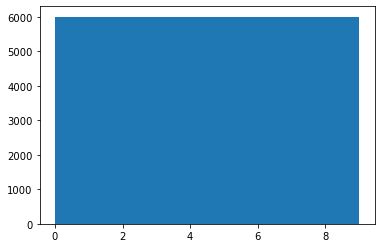

In [17]:
plt.hist(tr_set['label'])

So we can see that the training data is equally composed.

Let's try to look at random sample:

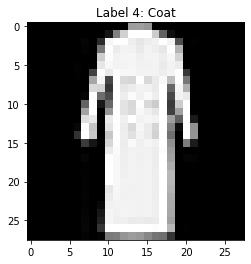

In [75]:
rand_sample = tr_set.iloc[[randint(0, 60000)]]
rand_label = int(rand_sample['label'])
rand_img = np.array(rand_sample, dtype='float')
rand_img = rand_img[:, 1:]
rand_img = rand_img.reshape((28,28))

plt.imshow(rand_img, cmap='gray')
plt.title("Label {0}: {1}".format(rand_label, label_names[rand_label]))
plt.show()

In [41]:
label

39206    8
Name: label, dtype: int64